# Miniproject 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [4]:
def clean_data(movies_file, data_file):
    unique_title_id_map = {}  # to keep track of titles that already have an id
    needed_updates = {}  # this array will map ids that need to be changed to the id
    # they should be changed to
    with open(movies_file, 'r') as f:
        for line in f:
            line_data = line.strip('\n').split('\t')
            movie_id, title = line_data[0], line_data[1]
            if str(title) in unique_title_id_map:
                needed_updates[movie_id] = unique_title_id_map[str(title)]
            else:
                unique_title_id_map[str(title)] = str(movie_id)
    # print(needed_updates)

    data_arr = np.loadtxt(data_file, dtype=np.int)
    for i, row in enumerate(data_arr):
        if str(row[1]) in needed_updates:
            data_arr[i, 1] = needed_updates[str(row[1])]
    return (data_arr)

In [5]:
Y_train = np.loadtxt('data/train.txt').astype(int)
Y_test = np.loadtxt('data/test.txt').astype(int)

#movie_cols = ['Movie ID','Movie Title', 'Unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
#'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

data_arr = clean_data('data/movies.txt','data/data.txt')

#rat_cols = ['User ID', 'Movie ID', 'Rating']
#ratings = np.loadtxt('data/data.txt', names=rat_cols)

OSError: data/train.txt not found.

In [ ]:
print(data_arr)

## HW 5 Code:

In [6]:
def grad_U(Ui, Yij, Vj, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    return eta*(reg*Ui - Vj*(Yij - np.dot(Ui,Vj)))


def grad_V(Ui, Yij, Vj, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """
    return eta*(reg*Vj - Ui*(Yij - np.dot(Ui,Vj)))

def get_err(U, V, Y, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    N,D = Y.shape
    err = 0
    
    for n in range(N):
        i = Y[n,0] - 1
        j = Y[n,1] - 1
        yij = Y[n,2]
        err += (yij - np.dot(U[i], V[j]))**2
        
    U_norm = np.linalg.norm(U)
    V_norm = np.linalg.norm(V)
    
    return (reg/2 *(U_norm**2 + V_norm**2) + err/2) / N

def train_model(M, N, K, eta, reg, Y, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """
    
    U = np.random.random((M,K)) - 0.5
    V = np.random.random((N,K)) - 0.5
    P,_ = Y.shape
    first_err = get_err(U,V,Y,reg)
    first_delta = 0
    prev_err = first_err
    cur_err = first_err
    
    for epoch in range(max_epochs):
        indices = np.random.permutation(P)
        for p in indices:
            i = Y[p,0] - 1
            j = Y[p,1] - 1
            yij = Y[p,2]
            U[i,:] = U[i,:] - grad_U(U[i,:], yij, V[j,:], reg, eta)
            V[j,:] = V[j,:] - grad_V(V[j,:], yij, U[i,:], reg, eta)
            
        cur_err = get_err(U,V,Y,reg)
        
        if epoch == 0:
            first_delta = np.abs(first_err - cur_err)
            
        cur_delta = np.abs(prev_err - cur_err)
        
        if cur_delta/first_delta < eps:
            return (U, V, cur_err)
            
        prev_err = cur_err
    
    return (U, V, cur_err)

In [14]:
M = max(max(Y_train[:,0]), max(Y_test[:,0])).astype(int) # users
N = max(max(Y_train[:,1]), max(Y_test[:,1])).astype(int) # movies

K = 20

reg = 0.0
eta = 0.03 # learning rate
E_in = 0
E_out = 0

# Use to compute Ein and Eout
U,V, err = train_model(M, N, K, eta, reg, Y_train)
E_in = err
E_out = get_err(U, V, Y_test)

In [39]:
def visualize_2d(M):
    """Project a matrix into 2 dimensions and visualize it.

    If the input is mxn, produces a 2xn projection using the first two left singular vectors of M,
    and produces a scatterplot of the columns of this projection.

    If list index is provided, plots only the subset of columns indicated.

    If labels are provided, the indicated points are labeled in place on the graph (based on index
    matching between the labels list and the columns of the projection).

    If filename is provided, outputs the plot to the file indicated. Otherwise, outputs to the
    current matplotlib device.

    """
    A, sigma, B = np.linalg.svd(M)
    M_proj = np.matmul(A[:,:2].transpose(), M)

    index = range(M.shape[1])
    plt.close('all')
    ax = plt.figure().gca()
    ax.scatter(M_proj[0,index], M_proj[1,index], marker='.')

    plt.show()

    return M_proj

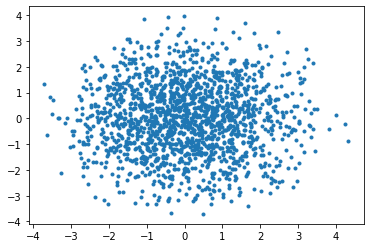

array([[ 2.1331571 , -0.13381613, -0.5430355 , ..., -0.95152751,
        -2.6267477 ,  2.26331965],
       [-0.43075599,  0.45529865, -0.22398199, ...,  0.49379498,
        -0.21144877,  0.73748841]])

In [40]:
visualize_2d(V.T)

## Off the Shelf Code:

In [28]:
train_data_matrix = np.zeros((M,N))
for n in range(Y_train.shape[0]):
    i = Y_train[n,0] - 1
    j = Y_train[n,1] - 1
    yij = Y_train[n,2]
    train_data_matrix[i][j] = yij

In [29]:
from sklearn.metrics.pairwise import pairwise_distances
user_sim = pairwise_distances(train_data_matrix, metric='cosine')
item_sim = pairwise_distances(train_data_matrix.T, metric='cosine')

In [30]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [31]:
item_pred = predict(train_data_matrix, item_sim, type='item')
user_pred = predict(train_data_matrix, user_sim, type='user')

In [7]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

NameError: name 'train_data_matrix' is not defined

In [1]:
visualize_2d(vt)

NameError: name 'visualize_2d' is not defined

In [34]:
## Error:

In [35]:
get_err(np.dot(u, np.diag(s)), vt.T, Y_train)

2.4833788027802544

In [36]:
get_err(U, V, Y_train)

10.71084433481197

In [37]:
get_err(np.dot(u, np.diag(s)), vt.T, Y_test)

3.131012715645948

In [38]:
get_err(U, V, Y_test)

14.714729730227404